In [1]:
!pip install transformers

In [2]:
import os
import logging
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
from random import randint, shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    ConfusionMatrixDisplay,
    accuracy_score,
    f1_score
)

import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import AutoModel, AutoTokenizer

In [3]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/AY24 25 Sem 2/CS5246/Text Mining Group Project

/content/drive/MyDrive/AY24 25 Sem 2/CS5246/Text Mining Group Project


In [5]:
# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sns.set_theme()

In [6]:
import sys
sys.path.append('/content/drive/MyDrive/AY24 25 Sem 2/CS5246/Text Mining Group Project/Model')

from Utils import *

In [7]:
import random
import numpy as np
import torch

def set_seed(seed=123):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # for CUDA
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False  # for reproducibility

set_seed(123)

# Training

In [8]:
train_data_path = "Data/Dataset 2_final_df6_train.xlsx"
val_data_path = "Data/Dataset 2_final_df6_val.xlsx"
test_data_path = 'Data/Dataset 2_final_df6_test.xlsx'
sheet_name = "Sheet1"

In [9]:
model_ckpt = "bert-base-uncased"
batch_size = 16

train_ds = SocialMediaDS(
    data_path=train_data_path,
    sheet_name=sheet_name,
    model_ckpt=model_ckpt,
    device=device
)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=True, collate_fn=train_ds.collate_fn)

val_ds = SocialMediaDS(
    data_path=val_data_path,
    sheet_name=sheet_name,
    model_ckpt=model_ckpt,
    device=device
)
val_dl = DataLoader(val_ds, batch_size=batch_size, collate_fn=val_ds.collate_fn)

test_ds = SocialMediaDS(
    data_path=test_data_path,
    sheet_name=sheet_name,
    model_ckpt=model_ckpt,
    device=device
)
test_dl = DataLoader(test_ds, batch_size=batch_size, collate_fn=test_ds.collate_fn)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [10]:
print(f'Size of training data: {len(train_ds)}')
print(f'Size of validation data: {len(val_ds)}')
print(f'Size of test data: {len(test_ds)}')

Size of training data: 8148
Size of validation data: 1019
Size of test data: 1019


In [11]:
model = EmotionClassifier(model_ckpt, emotion_nlabels=7).to(device)
model.unfreeze_encoder()

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


In [12]:
epochs = 5
loss_fn = focal_loss(2)
optimizer = optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.01)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

In [13]:
mem = train_and_validate(
    model=model,
    train_dl=train_dl,
    val_dl=val_dl,
    loss_fn=loss_fn,
    optimizer=optimizer,
    scheduler=scheduler,
    model_save_path="Model/saved_models/model_masked_dataset2.pth",
    epochs=5
)

Training:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/5
Train Loss: 1.718	Acc: 0.364	F1: 0.377
Val Loss:   1.309	Acc:   0.548	F1:   0.525

New best F1: 0.525 - Model saved!
Epoch 2/5
Train Loss: 1.151	Acc: 0.510	F1: 0.518
Val Loss:   1.025	Acc:   0.554	F1:   0.534

New best F1: 0.534 - Model saved!
Epoch 3/5
Train Loss: 0.838	Acc: 0.620	F1: 0.624
Val Loss:   1.094	Acc:   0.579	F1:   0.570

New best F1: 0.570 - Model saved!
Epoch 4/5
Train Loss: 0.577	Acc: 0.723	F1: 0.727
Val Loss:   1.149	Acc:   0.558	F1:   0.543

Epoch 5/5
Train Loss: 0.406	Acc: 0.804	F1: 0.810
Val Loss:   1.336	Acc:   0.575	F1:   0.568

Training completed!


# Evaluation

In [14]:
emo_preds, emo_targets, all_texts = evaluate_model(model, test_ds, test_dl)

  0%|          | 0/64 [00:00<?, ?it/s]

                precision    recall  f1-score   support
0                   31.37     21.62     25.60        74
1                   45.57     40.45     42.86       178
2                   42.31     37.93     40.00        29
3                   57.71     74.11     64.89       197
4                   62.78     64.62     63.69       342
5                   55.68     51.85     53.70       189
6                    0.00      0.00      0.00        10

accuracy                                55.35      1019
macro avg           42.20     41.51     41.53      1019
weighted avg        54.00     55.35     54.36      1019


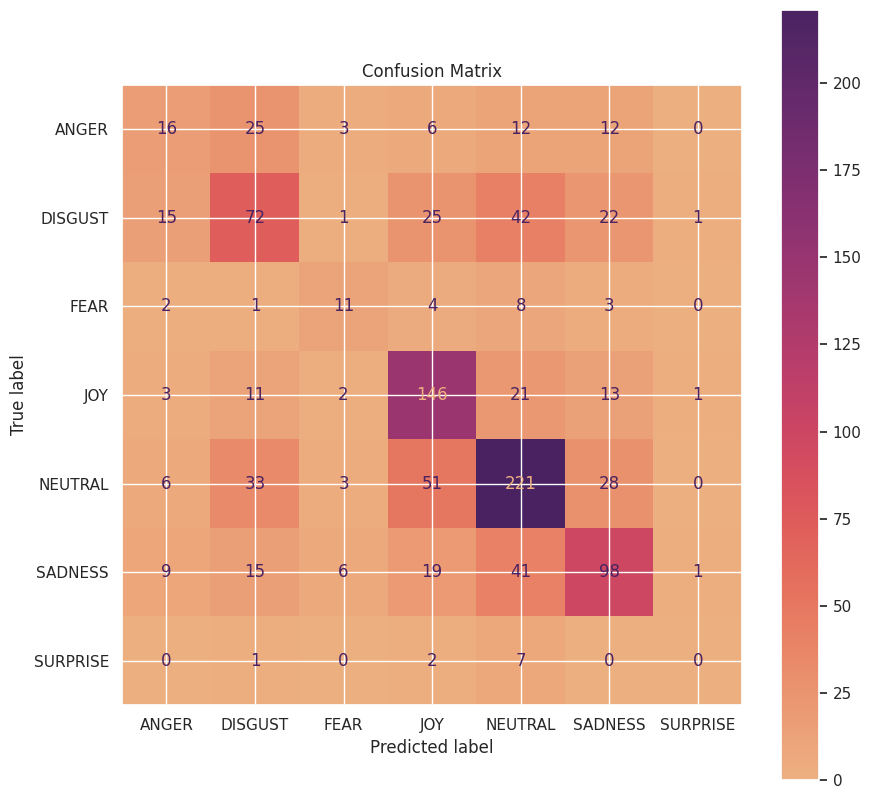

In [15]:
plot_confusion_matrix(emo_preds, emo_targets)